# ECE 232E Project 1 - Random Graphs and Random Walks
By Anthony Lei, Swetha Pillai, and Morgan Worthington

In [2]:
install.packages("igraph")
install.packages("pracma")

library('igraph')
library('Matrix')
library('pracma')

install.packages('matrixStats')
library(matrixStats)


The downloaded binary packages are in
	/var/folders/nt/t764cvhn2l95gxbxxlzq8ksh0000gn/T//Rtmpm8Krsc/downloaded_packages

The downloaded binary packages are in
	/var/folders/nt/t764cvhn2l95gxbxxlzq8ksh0000gn/T//Rtmpm8Krsc/downloaded_packages



Attaching package: 'igraph'


The following objects are masked from 'package:stats':

    decompose, spectrum


The following object is masked from 'package:base':

    union



Attaching package: 'pracma'


The following objects are masked from 'package:Matrix':

    expm, lu, tril, triu





The downloaded binary packages are in
	/var/folders/nt/t764cvhn2l95gxbxxlzq8ksh0000gn/T//Rtmpm8Krsc/downloaded_packages


# 1. Generating Random Networks

first third - Anthony

second third - Swetha

## 3. Create a modified preferential attachment model that penalizes the age of a node

(a) Produce such an undirected network with 1000 nodes and parameters m = 1,
α = 1, β = −1, and a = c = d = 1, b = 0. Plot the degree distribution. What is the
power law exponent?

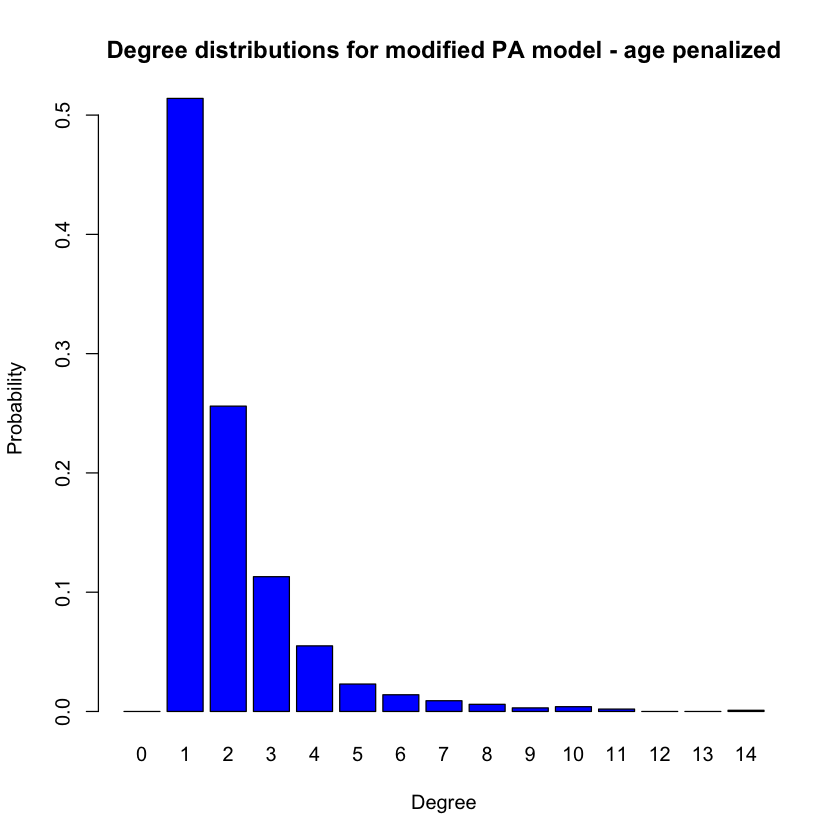

In [3]:
pa_age <- sample_pa_age(1000, m=1, pa.exp=1, aging.exp=-1, zero.deg.appeal=1, zero.age.appeal=0, deg.coef=1, age.coef=1, directed=FALSE)

# Plotting the node degree distribution as a bar plot
node_deg_dist = degree.distribution(pa_age)
xVals = c(0: (length(node_deg_dist) - 1))
barplot(node_deg_dist, names.arg=xVals, xlab="Degree", ylab="Probability",
        main = paste("Degree distributions for modified PA model - age penalized", sep = " "),col="blue")


Call:
lm(formula = log10(probability) ~ log10(degree))

Residuals:
     Min       1Q   Median       3Q      Max 
-0.33734 -0.13183  0.04749  0.08599  0.20948 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)     0.0483     0.1238    0.39    0.705    
log10(degree)  -2.5204     0.1554  -16.22 1.65e-08 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.1729 on 10 degrees of freedom
Multiple R-squared:  0.9634,	Adjusted R-squared:  0.9597 
F-statistic:   263 on 1 and 10 DF,  p-value: 1.648e-08


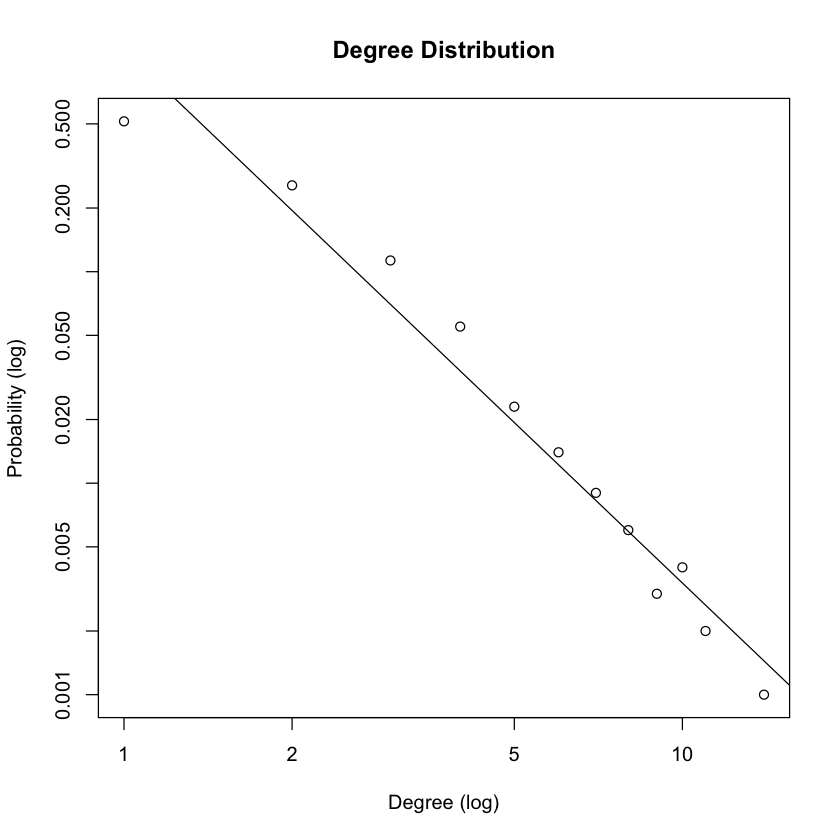

In [4]:
plot_degree_distribution = function(graph) {
  # calculate degree
  d = degree(graph, mode = "all")
  dd = degree.distribution(graph, mode = "all", cumulative = FALSE)
  degree = 1:max(d)
  probability = dd[-1]
  # delete blank values
  nonzero.position = which(probability != 0)
  probability = probability[nonzero.position]
  degree = degree[nonzero.position]
  # plot
  plot(probability ~ degree, log = "xy", xlab = "Degree (log)", ylab = "Probability (log)", 
       col = 1, main = "Degree Distribution")
  abline(lm(log10(probability) ~ log10(degree)))
  summary(lm(log10(probability) ~ log10(degree)))
}

plot_degree_distribution(pa_age)

From the lectures, the power-law exponent corresponds to the slope of the linear regression on the log-log plot. Here, it is approximately -2.5.

(b) Use fast greedy method to find the community structure. What is the modularity?

In [5]:
modularity(cluster_fast_greedy(pa_age))

[1] 0.9358698

last third - Morgan